In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
import pickle
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')

%matplotlib widget

In [25]:
dir = './S21s_2024115_14h48/'
freqs, dark_s21 = np.load(dir + 'S21_dark.npy')
M_pxs = 20
N_pxs = 20

393


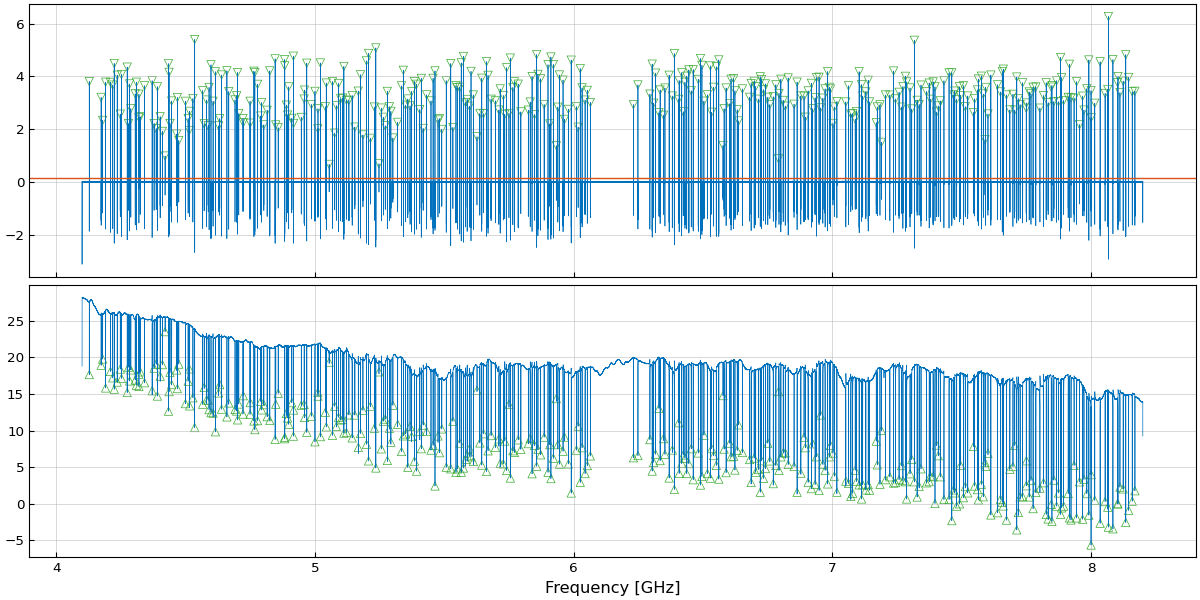

In [26]:
sw = 3 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='o')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [27]:
files = natsorted(glob(dir+'*_*0.npy'))
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['./S21s_2024115_14h48\\S21_x1y0.npy', './S21s_2024115_14h48\\S21_x2y0.npy', './S21s_2024115_14h48\\S21_x3y0.npy', './S21s_2024115_14h48\\S21_x4y0.npy', './S21s_2024115_14h48\\S21_x5y0.npy', './S21s_2024115_14h48\\S21_x6y0.npy', './S21s_2024115_14h48\\S21_x7y0.npy', './S21s_2024115_14h48\\S21_x8y0.npy', './S21s_2024115_14h48\\S21_x9y0.npy', './S21s_2024115_14h48\\S21_x10y0.npy', './S21s_2024115_14h48\\S21_x11y0.npy', './S21s_2024115_14h48\\S21_x12y0.npy', './S21s_2024115_14h48\\S21_x13y0.npy', './S21s_2024115_14h48\\S21_x14y0.npy', './S21s_2024115_14h48\\S21_x15y0.npy', './S21s_2024115_14h48\\S21_x16y0.npy', './S21s_2024115_14h48\\S21_x17y0.npy', './S21s_2024115_14h48\\S21_x18y0.npy', './S21s_2024115_14h48\\S21_x19y0.npy', './S21s_2024115_14h48\\S21_x20y0.npy']


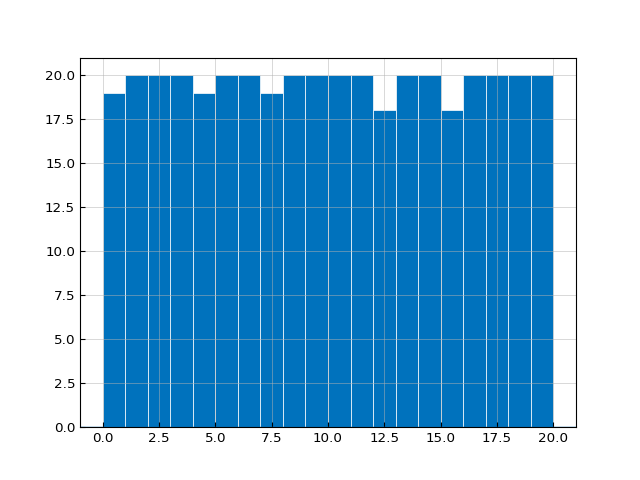

In [28]:
pos = np.empty((nr_kids, 4))
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = locs
pos[:, 2] = f0s
for i in range(nr_kids):
    pos[i, 3] = np.nanargmax(s21s[:, i])
pos[108, 3] -= 1
fig, ax = plt.subplots()
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), edgecolor='w')
ax.axhline()

In [29]:
pos[0]

array([  0.        , 894.        ,   4.12792899,   0.        ])

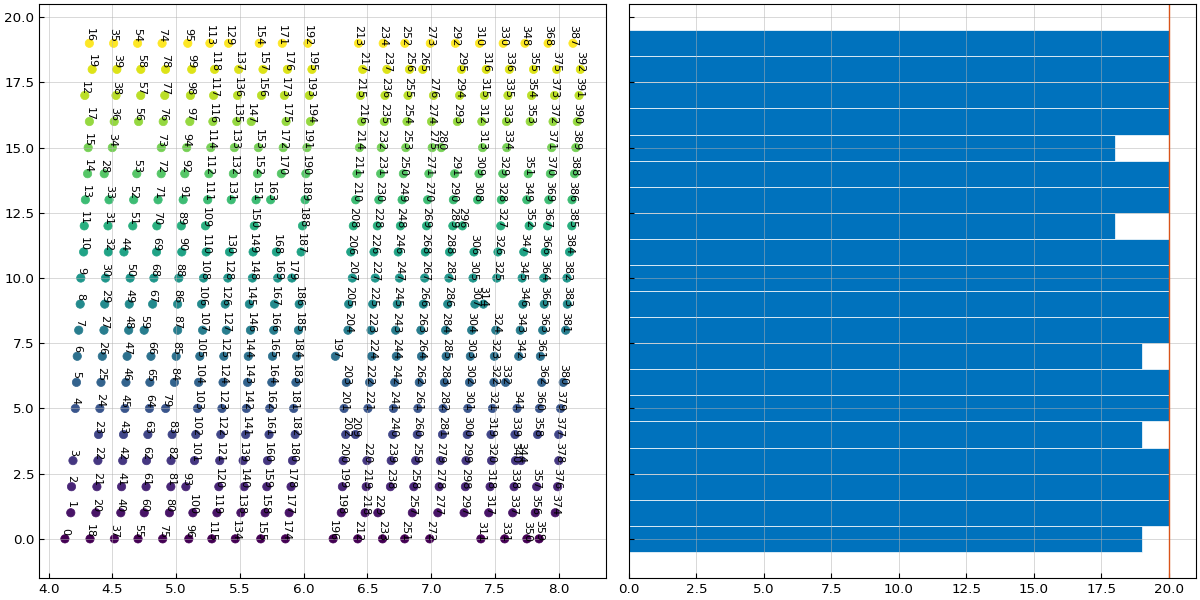

In [30]:
fig, ax = plt.subplot_mosaic('ab', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].scatter(pos[:, 2], pos[:, 3], c=pos[:, 3], cmap='viridis')
for i, txt in enumerate(pos[:, 0]):
    ax['a'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['b'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, edgecolor='w', orientation='horizontal')
ax['b'].axvline(nr_steps, c='o')


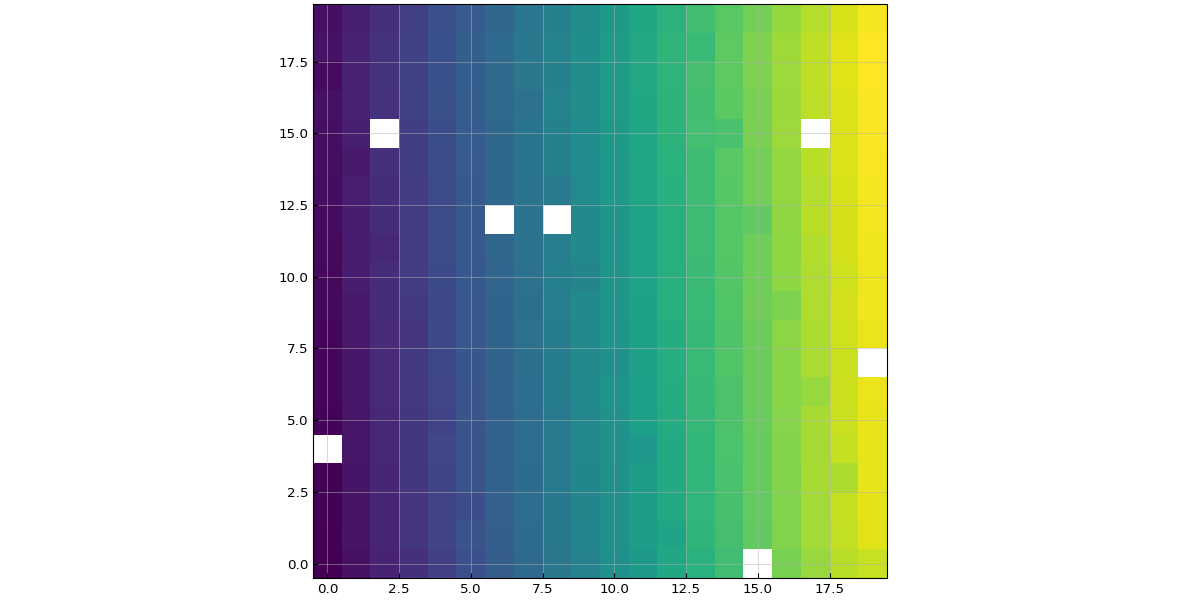

In [31]:
rows = [[] for _ in range(nr_steps)]
for i in pos:
    rows[int(i[-1])].append(int(i[0]))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
kids_derolled
nans = [[0, 15], [4, 0], [7, 19], [12, 6], [12, 8], [15, 2], [15, 17]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled

fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')
# for i, txt in enumerate(pos[:, 0]):
#     ax['a'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)


array([[  0.,  18.,  37.,  55.,  75.,  96., 115., 134., 155., 174., 196.,
        212., 233., 251., 272.,  nan, 311., 331., 350., 359.],
       [257., 277., 297., 317., 337., 356., 374.,   1.,  20.,  40.,  60.,
         80., 100., 119., 138., 158., 177., 198., 218., 229.],
       [120., 140., 159., 178., 199., 219., 238., 258., 278., 298., 318.,
        338., 357., 376.,   2.,  21.,  41.,  61.,  81.,  93.],
       [378.,   3.,  22.,  42.,  62.,  82., 101., 121., 139., 160., 180.,
        200., 220., 239., 259., 279., 299., 320., 340., 344.],
       [240., 260., 281., 300., 319., 339., 358., 377.,  nan,  23.,  43.,
         63.,  83., 102., 122., 141., 161., 182., 202., 209.],
       [103., 123., 142., 162., 181., 201., 221., 241., 261., 282., 301.,
        321., 341., 360., 379.,   4.,  24.,  45.,  64.,  79.],
       [362., 380.,   5.,  25.,  46.,  65.,  84., 104., 124., 143., 164.,
        183., 203., 222., 242., 262., 283., 302., 322., 332.],
       [224., 244., 264., 285., 303., 323

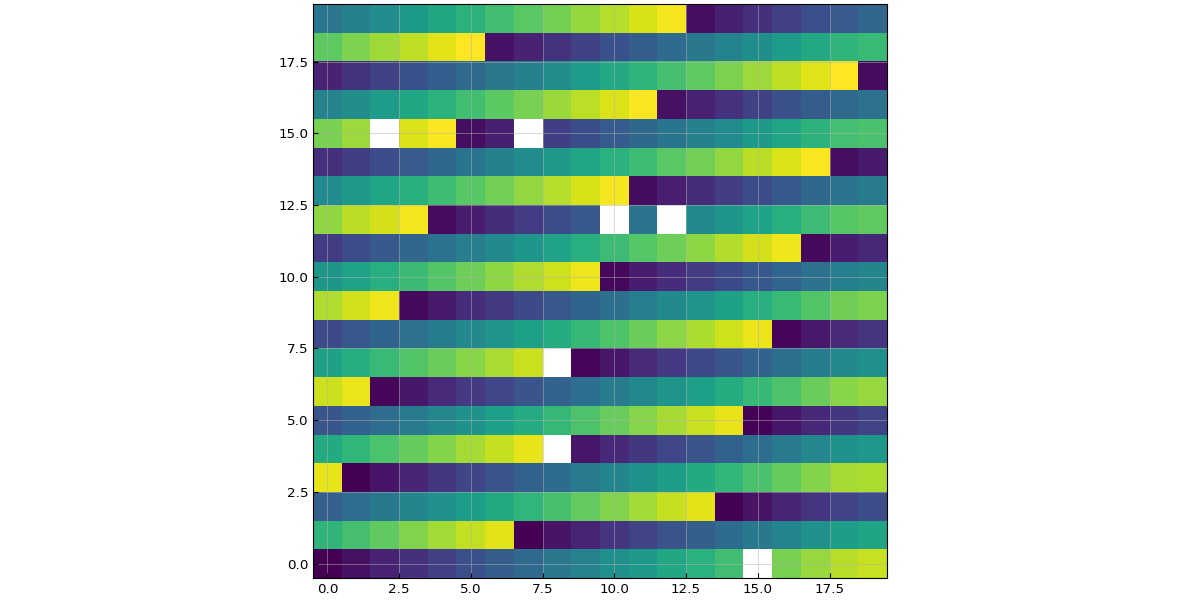

In [32]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*7)
kids[~np.isnan(kids)] = kids[~np.isnan(kids)].astype(int)
# kids[1:20:2] = np.nan
fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')
kids

In [33]:
kid_id_board = np.load('kid_id_board_20x20.npy').astype(int)
kid_id_board

array([[  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [261, 281, 301, 321, 341, 361, 381,   1,  21,  41,  61,  81, 101,
        121, 141, 161, 181, 201, 221, 241],
       [122, 142, 162, 182, 202, 222, 242, 262, 282, 302, 322, 342, 362,
        382,   2,  22,  42,  62,  82, 102],
       [383,   3,  23,  43,  63,  83, 103, 123, 143, 163, 183, 203, 223,
        243, 263, 283, 303, 323, 343, 363],
       [244, 264, 284, 304, 324, 344, 364, 384,   4,  24,  44,  64,  84,
        104, 124, 144, 164, 184, 204, 224],
       [105, 125, 145, 165, 185, 205, 225, 245, 265, 285, 305, 325, 345,
        365, 385,   5,  25,  45,  65,  85],
       [366, 386,   6,  26,  46,  66,  86, 106, 126, 146, 166, 186, 206,
        226, 246, 266, 286, 306, 326, 346],
       [227, 247, 267, 287, 307, 327, 347, 367, 387,   7,  27,  47,  67,
         87, 107, 127, 147, 167, 187, 207],
       [ 88, 108, 128, 148, 168, 188, 208, 228, 248, 268, 288, 3

In [34]:
master_array = np.loadtxt(r'C:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\Mappings\LT361w2chip4\LT361w2chip4_master.txt', delimiter=',', skiprows=1)
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        master_array[idx, 1] = i
        master_array[idx, 2] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master_array[idx, -1] = meas_f
mask = np.isnan(master_array[:, -1])


array([398.        ,  18.        ,   5.        ,  95.04722   ,
        12.07329   ,   7.890955  ,   8.220898  ,   8.223389  ,
        94.91714   ,   8.16957178])

In [35]:
master_array[0]

array([  0.        ,   0.        ,   0.        , 727.4812    ,
        92.39718   ,   4.1       ,   4.15617   ,   4.15617   ,
       727.4812    ,   4.12792899])

In [37]:
master = {}
master['design'] = {}
master['design']['f0'] = master_array[:, 5]
master['design']['fingers'] = master_array[:, 3]
master['design']['couplers'] = master_array[:, 4]
master['design']['row'] = master_array[:, 1]
master['design']['col'] = master_array[:, 2]
master['measured'] = {}
master['measured']['f0'] = master_array[:, 6]
master['trimdesign'] = {}
master['trimdesign']['f0'] = master_array[:, 7]
master['trimdesign']['fingers'] = master_array[:, 8]
master['trimmeasured'] = {} 
master['trimmeasured']['f0'] = master_array[:, 9]
# with open('../Masters/LT361chip4_master.pkl', 'wb') as f:
#     pickle.dump(master, f)

In [12]:
# Define column headers
headers = "idx, row, col, L_finger, L_coupler, f0_design, f0_meas, f0_design_nibble, L_finger_nibble, f0_meas_nibble"

# Save the master_array as a text file with headers
# np.savetxt("LT361w2chip4_master.txt", master_array, header=headers, comments='', fmt='%.6e', delimiter=',')

In [13]:
master_trim_array = np.load('master_trim_array.npy')
remove = np.ones(395)
remove[[293, 355]] = 0  
trimmed_array = master_trim_array[remove.astype(bool)]    
fingers = trimmed_array[:, -1]
trims = trimmed_array[:, 4]
design_f0s = trimmed_array[:, 3]
design_f0s_original = trimmed_array[:, 2]
design_f0s

idx_80 = np.where(trimmed_array[:, -2] == 0.08)[0]  
idx_0 = np.where(trimmed_array[:, -2] == 0)[0]  
idx_trim = np.where((trimmed_array[:, -2] != 0) & (trimmed_array[:, -2] != 0.08))[0] 
# idx_2little = np.load('ids2little.npy')
idx_all = np.arange(len(f0s), dtype=int) 

ids_even = kids[0:21:2].flatten()
ids_odd = kids[1:21:2].flatten()

In [14]:
master_trim_array[394]

array([3.94000000e+02, 3.98000000e+02, 8.22089842e+00, 8.22338916e+00,
       1.30083960e-01, 9.50472207e+01])

In [15]:
design = design_f0s
original = design_f0s_original
meas = f0s
df_f = (meas-design) / design
xs = np.empty(df_f.shape)
xs[:] = np.nan
ys = copy(xs)

df_f_corr = copy(df_f)
df_fmap = np.empty((M_pxs, N_pxs))
df_fmap[:] = np.nan
count = 0
idx = idx_all
for i, row in enumerate(kids):
    for j, k in enumerate(row):
        if ~np.isnan(k):
            if np.sum(idx == int(k)) == 1:
                df_fmap[i, j] = df_f_corr[int(k)]
                ys[int(k)] = i
                xs[int(k)] = j
                count += 1
flim = np.array([np.min((design, meas)), np.max((design, meas))])

fit = design
label = 'f_0^{D}'
save = 'nofit'
size=20


-0.006715495849091908


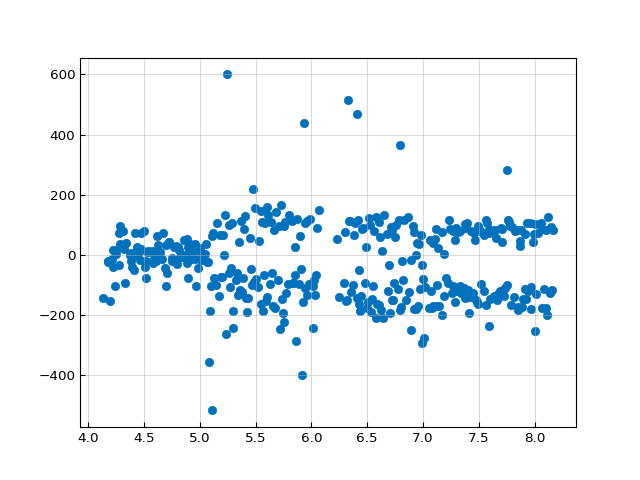

In [16]:
new_fingers = fingers+trims
corr_design = design*(1+np.mean(df_f_corr[idx_0]))
print(np.mean(df_f_corr[idx_0]))
def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, corr_design, new_fingers)
actual_fingers = poly(meas, *popt) - (poly(corr_design, *popt) - new_fingers)

misalign = (new_fingers - actual_fingers)*1e3
misalign_map = np.empty((M_pxs, N_pxs)) 
misalign_map[:] = np.nan
for i, row in enumerate(kids):
    for j, k in enumerate(row):
        if ~np.isnan(k):
            if np.sum(idx == int(k)) == 1:
                misalign_map[i, j] = misalign[int(k)]
                count += 1
fig, ax = plt.subplots()
ax.scatter(meas, misalign)

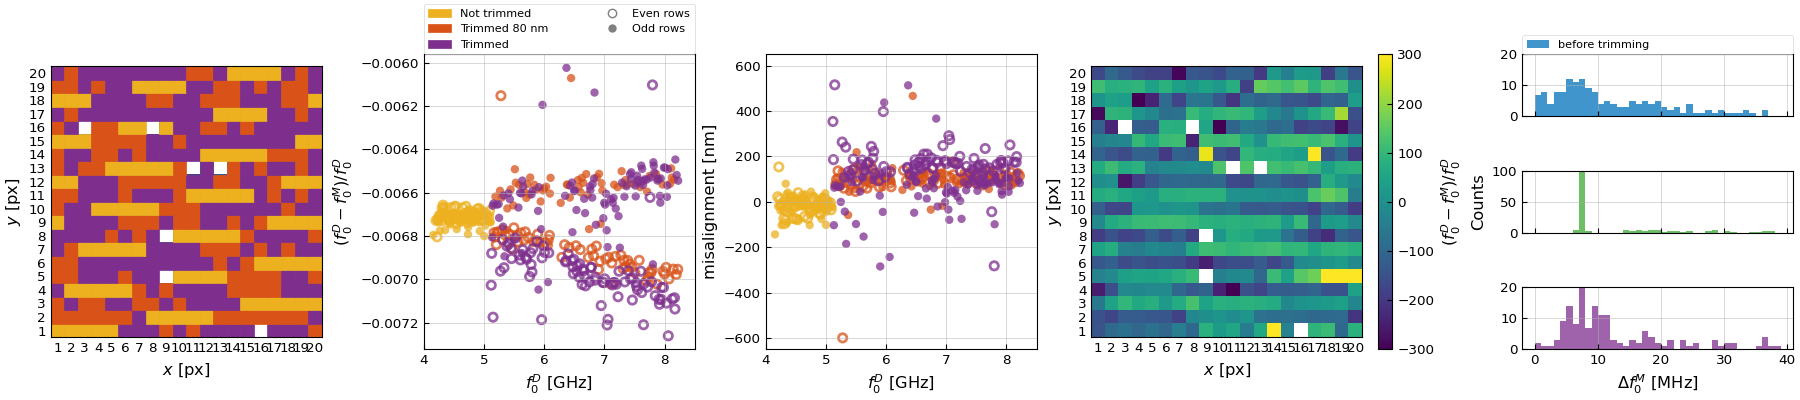

In [17]:
from matplotlib.patches import Patch

fig, ax = plt.subplot_mosaic('abgcd;abgce;abgcf', figsize=(18,4), constrained_layout=True)

im = ax['a'].imshow(df_fmap, cmap='viridis', origin='lower')
for i, x in enumerate(df_fmap):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if np.isin(new_id, idx_0):
                c = 'y'
            elif np.isin(new_id, idx_80):
                c = 'o'
            elif np.isin(new_id, idx_trim):
                c = 'p'
            if np.isin(new_id, ids_even):
                ax['a'].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=c, alpha=1))
            else:
                ax['a'].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, color=c, alpha=1))
                # ax['a'].add_patch(plt.Circle((j, i), radius=.2, color='w', alpha=1))
ax['a'].set_xticks(np.arange(0, size, 1))
ax['a'].set_yticks(np.arange(0, size, 1))
ax['a'].set_xticklabels(np.arange(1, size+1, 1), )
ax['a'].set_yticklabels(np.arange(1, size+1, 1))
ax['a'].tick_params(which='major', bottom=False, left=False)
ax['a'].set_xlabel('$\it x$ $[px]$')
ax['a'].set_ylabel('$\it y$ $[px]$')
ax['a'].grid(False)
# handles = [Patch(color='y'),Patch(color='o'),Patch(color='p')]
# labels = ['Not trimmed', 'Trimmed 80 nm', 'Trimmed']
# ax['a'].legend(handles, labels,  bbox_to_anchor=(0., 1, 1., .102), loc='lower left',
#         ncols=3, mode="expand", borderaxespad=0.)

clr = 'y'	
misaligns_control = []
misaligns_offset = []
misaligns = []
# ax['b'].axhline(np.mean(df_f_corr[idx_0]), c=clr, ls='--', lw=1, label='Fractional shift due to processing')
i = idx_0[np.isin(idx_0, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
misaligns_control.append(misalign[i])
i = idx_0[np.isin(idx_0, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], -misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
misaligns_control.append(misalign[i])
clr = 'o'	
i = idx_80[np.isin(idx_80, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
misaligns_offset.append(misalign[i])
i = idx_80[np.isin(idx_80, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], -misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
misaligns_offset.append(-misalign[i])
clr = 'p'	
i = idx_trim[np.isin(idx_trim, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
misaligns.append(misalign[i])
i = idx_trim[np.isin(idx_trim, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(design[i], -misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
misaligns.append(-misalign[i])
clim = [0.0060, 0.0073]
# ax['b'].set_ylim(clim)
ax['b'].set_xlim([4, 8.5])
ax['b'].set_ylabel('$\it (%s-f_0^{M})/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{D}$ $[GHz]$')
ax['g'].set_ylim([-650, 650])
ax['g'].set_xlim([4, 8.5])
ax['g'].set_ylabel('misalignment [nm]')
ax['g'].set_xlabel('$\it f_0^{D}$ $[GHz]$')
handles = [Patch(color='y'),Patch(color='o'),Patch(color='p'),
    # plt.Line2D([0], [0], marker='o', color='y', markerfacecolor='None', markeredgecolor='y', lw=2),
    # plt.Line2D([0], [0], marker='o', color='o', markerfacecolor='None', markeredgecolor='o', lw=2),
    # plt.Line2D([0], [0], marker='o', color='p', markerfacecolor='None', markeredgecolor='p', lw=2),
    plt.Line2D([0], [0], marker='o', color='None', markerfacecolor='None', markeredgecolor='gray', lw=2),
    plt.Line2D([0], [0], marker='o', color='None', markerfacecolor='gray', markeredgecolor='None', lw=1)
]
labels = ['Not trimmed', 'Trimmed 80 nm', 'Trimmed', 'Even rows', 'Odd rows', 'Fractional shift due to processing']
ax['b'].legend(handles, labels, bbox_to_anchor=(0., 1, 1., .102), loc='lower left',
        ncols=2, mode="expand", borderaxespad=0.)

im = ax['c'].imshow(misalign_map, cmap='viridis', origin='lower', vmin=-300, vmax=300)
# for i, x in enumerate(df_fmap):
#     for j, y in enumerate(x):
#         if ~np.isnan(y):
#             new_id = kids[i, j]
#             ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='w')
ax['c'].set_xticks(np.arange(0, size, 1))
ax['c'].set_yticks(np.arange(0, size, 1))
ax['c'].set_xticklabels(np.arange(1, size+1, 1), )
ax['c'].set_yticklabels(np.arange(1, size+1, 1))
ax['c'].tick_params(which='major', bottom=False, left=False)
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
_ = cbar.ax.set_ylabel('$\it (%s-f_0^{M})/%s$' % (label, label))
ax['c'].grid(False)

ftrims = meas[idx_trim]
df_trims = ftrims[1:]-ftrims[:-1]
fdesign = design[idx_trim]
df_design = fdesign[1:]-fdesign[:-1]
forg = design_f0s_original[idx_trim]
df_org = forg[1:]-forg[:-1]

ax['d'].hist(df_org*1e3, bins=np.arange(40), alpha=.75, label='before trimming', linewidth=1, facecolor='b')
ax['e'].hist(df_design*1e3, bins=np.arange(0, 40, 1), alpha=.75, label='design', linewidth=1, facecolor='g')
ax['f'].hist(df_trims*1e3, bins=np.arange(40), alpha=.75, label='after trimming', linewidth=1, facecolor='p')
ax['d'].set_ylim([0, 20])
ax['e'].set_ylim([0, 100])
ax['f'].set_ylim([0, 20])
ax['f'].set_xlabel('$\it \Delta f_0^{M}$ $[MHz]$')
ax['e'].set_ylabel('Counts')
ax['d'].set_xticklabels('')
ax['e'].set_xticklabels('')
ax['d'].legend(bbox_to_anchor=(0., 1, 1., .102), loc='lower left',
        ncols=3, mode="expand", borderaxespad=0.)

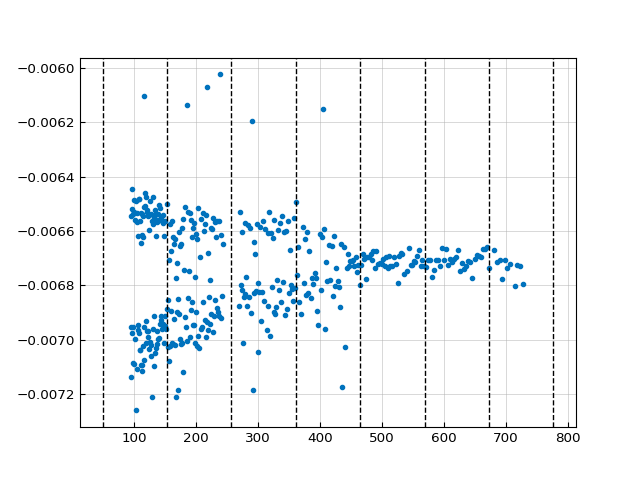

In [24]:
fig, ax = plt.subplots()
ax.plot(fingers, df_f, '.')
finger_lengths = np.linspace(7*7, 7*111, 8, endpoint=True)
for finger in finger_lengths:
    ax.axvline(finger, c='k', lw=1, ls='--')

In [18]:
misaligns = np.hstack(misaligns)
misaligns_offset = np.hstack(misaligns_offset)
misaligns_control = np.hstack(misaligns_control)
print(np.mean(misaligns_offset[(misaligns_offset > 0) & (misaligns_offset < 200)]))
print(np.std(misaligns_offset[(misaligns_offset > 0) & (misaligns_offset < 200)]))

101.9662354510415
26.047129694044482


(-400.0, 400.0)

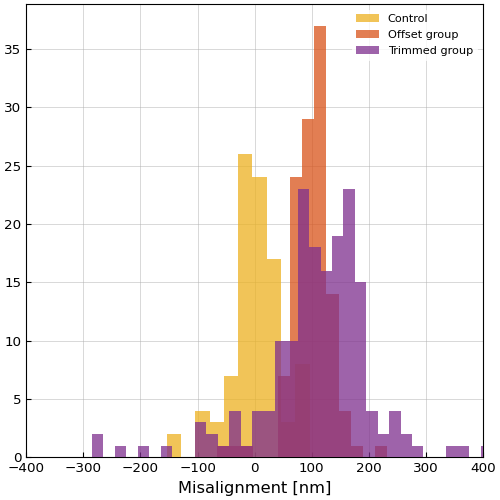

In [19]:
fig, ax = plt.subplot_mosaic('a', figsize=(5,5), constrained_layout=True, sharex=True, sharey=True)
ax['a'].hist(misaligns_control, label='Control', facecolor='y', bins=10, zorder=3, alpha=.75)	
ax['a'].hist(misaligns_offset, label='Offset group', facecolor='o', bins=50, zorder=3, alpha=0.75)	
ax['a'].hist(misaligns, label='Trimmed group', facecolor='p', bins=40, zorder=3, alpha=0.75)	
ax['a'].legend(edgecolor='w')
ax['a'].set_xlabel('Misalignment [nm]')
ax['a'].set_xlim([-400, 400])

(0.0, 30.0)

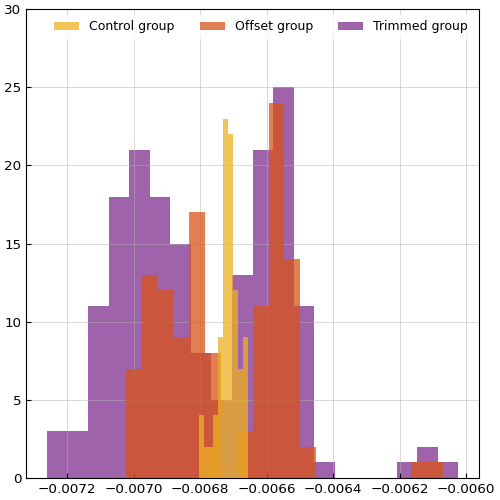

In [84]:
fig, ax = plt.subplot_mosaic('a', figsize=(5,5), constrained_layout=True, sharex=True, sharey=True)
i = idx_0
ax['a'].hist(df_f_corr[i], label='Control group', facecolor='y', bins=10, zorder=3, alpha=0.75)	
i = idx_80
ax['a'].hist(df_f_corr[i], label='Offset group', facecolor='o', bins=20, zorder=2, alpha=0.75)	
i = idx_trim
ax['a'].hist(df_f_corr[i], label='Trimmed group', facecolor='p', bins=20, zorder=1, alpha=0.75)	
ax['a'].legend(edgecolor='w', loc='upper right',ncols=3, fontsize=9)
ax['a'].set_ylim([0, 30])

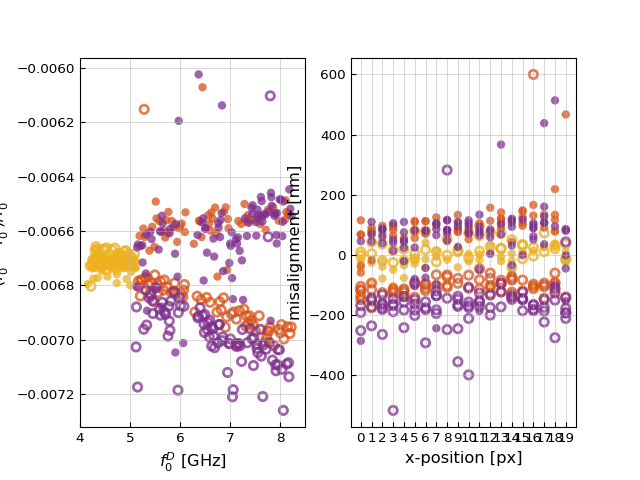

In [15]:
fig, ax = plt.subplot_mosaic('bg')
clr = 'y'	
# ax['b'].axhline(np.mean(df_f_corr[idx_0]), c=clr, ls='--', lw=1, label='Fractional shift due to processing')
i = idx_0[np.isin(idx_0, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
i = idx_0[np.isin(idx_0, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
clr = 'o'	
i = idx_80[np.isin(idx_80, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
i = idx_80[np.isin(idx_80, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
clr = 'p'	
i = idx_trim[np.isin(idx_trim, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c=clr, edgecolor='None', lw=2, marker='o', alpha=.75)
i = idx_trim[np.isin(idx_trim, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
ax['g'].scatter(xs[i], misalign[i], c='None', edgecolor=clr, lw=2, marker='o', alpha=.75)
clim = [0.0060, 0.0073]
# ax['b'].set_ylim(clim)
ax['b'].set_xlim([4, 8.5])
ax['b'].set_ylabel('$\it (%s-f_0^{M})/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{D}$ $[GHz]$')
# ax['g'].set_ylim([-500, 650])
# ax['g'].set_xlim([4, 8.5])
ax['g'].set_ylabel('misalignment [nm]')
ax['g'].set_xlabel('x-position [px]')
_ = ax['g'].set_xticks(np.arange(0, 20), minor=False)
ax['g'].grid(True, zorder=1)

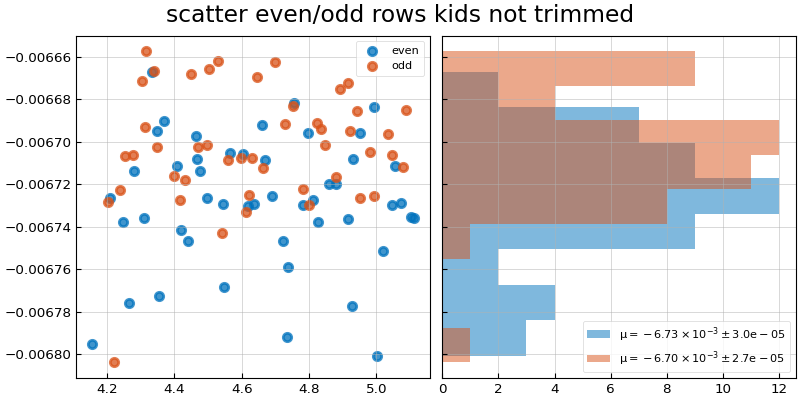

In [16]:
fig, ax = plt.subplot_mosaic('bc', sharey=True, figsize=(8,4), constrained_layout=True)
fig.suptitle('scatter even/odd rows kids not trimmed')
clr = 'y'	
i = idx_0[np.isin(idx_0, ids_even)]
ax['b'].scatter(design[i], df_f_corr[i], c='b', lw=2, marker='o', alpha=.75, label='even')
_ = ax['c'].hist(df_f_corr[i], alpha=.5, bins='auto', facecolor='b', orientation='horizontal', label='$\mu=%.2f\\times 10^{-3}\pm%.1e$' % (np.mean(df_f_corr[i])*1e3, np.std(df_f_corr[i])))
i = idx_0[np.isin(idx_0, ids_odd)]
ax['b'].scatter(design[i], df_f_corr[i], c='o', lw=2, marker='o', alpha=.75, label='odd')
_ = ax['c'].hist(df_f_corr[i], alpha=.5, bins='auto', facecolor='o', orientation='horizontal', label='$\mu=%.2f\\times 10^{-3}\pm%.1e$' % (np.mean(df_f_corr[i])*1e3, np.std(df_f_corr[i])))
ax['b'].legend()
ax['c'].legend()

[Text(0.0, 0, ''),
 Text(0.2, 0, ''),
 Text(0.4, 0, ''),
 Text(0.6000000000000001, 0, ''),
 Text(0.8, 0, ''),
 Text(1.0, 0, '')]

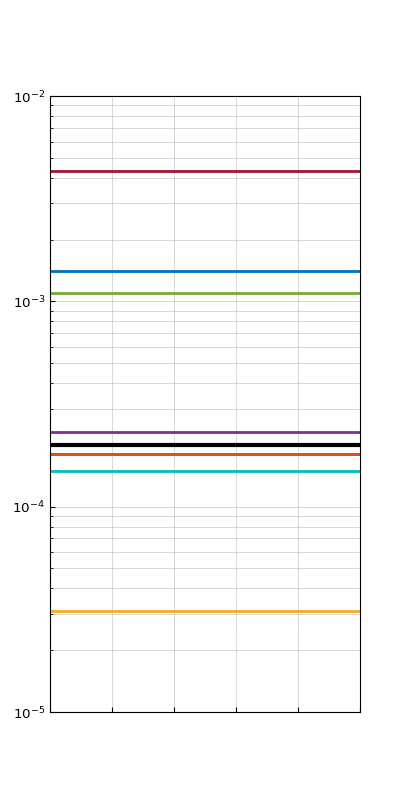

In [83]:
fig, ax = plt.subplots(figsize=(4,8))
ax.set_yscale('log')
a = 2
b = 3
ax.set_ylim([1e-5, 1e-2])
ax.axhline(4.3e-3, c='r', lw=a)
ax.axhline(2e-4, c='k', lw=b)
ax.axhline(1.4e-3, c='b', lw=a)
ax.axhline(1.1e-3, c='g', lw=a)
ax.axhline(3.1e-5, c='y', lw=a)
ax.axhline(1.8e-4, c='o', lw=a)
ax.axhline(1.8e-4, c='o', lw=a)
ax.axhline(2.3e-4, c='p', lw=a)
ax.axhline(1.5e-4, c='c', lw=a)
ax.set_xticklabels([])

In [17]:
scatter_all_even = np.std(df_f_corr[idx_all][np.isin(idx_all, ids_even)])
scatter_all_odd = np.std(df_f_corr[idx_all][np.isin(idx_all, ids_odd)])
scatter_all = np.std(df_f_corr[idx_all])
scatter_0_even = np.std(df_f_corr[idx_0][np.isin(idx_0, ids_even)])
scatter_0_odd = np.std(df_f_corr[idx_0][np.isin(idx_0, ids_odd)])
scatter_0 = np.std(df_f_corr[idx_0])
scatter_80_even = np.std(df_f_corr[idx_80][np.isin(idx_80, ids_even)])
scatter_80_odd = np.std(df_f_corr[idx_80][np.isin(idx_80, ids_odd)])
scatter_80 = np.std(df_f_corr[idx_80])
scatter_trim_even = np.std(df_f_corr[idx_trim][np.isin(idx_trim, ids_even)])
scatter_trim_odd = np.std(df_f_corr[idx_trim][np.isin(idx_trim, ids_odd)])
scatter_trim = np.std(df_f_corr[idx_trim])

print('scatter all: %.1e (even: %.1e, odd: %.1e)' % (scatter_all, scatter_all_even, scatter_all_odd))  
print('scatter fab: %.1e (even: %.1e, odd: %.1e)' % (scatter_0, scatter_0_even, scatter_0_odd))  
print('scatter prev fab: %.1e (even: %.1e, odd: %.1e)' % (scatter_80, scatter_80_even, scatter_80_odd))  
print('scatter new fab: %.1e (even: %.1e, odd: %.1e)' % (scatter_trim, scatter_trim_even, scatter_trim_odd))  

scatter all: 1.9e-04 (even: 1.3e-04, odd: 1.6e-04)
scatter fab: 3.1e-05 (even: 3.0e-05, odd: 2.7e-05)
scatter prev fab: 1.8e-04 (even: 8.8e-05, odd: 1.2e-04)
scatter new fab: 2.3e-04 (even: 1.5e-04, odd: 1.4e-04)


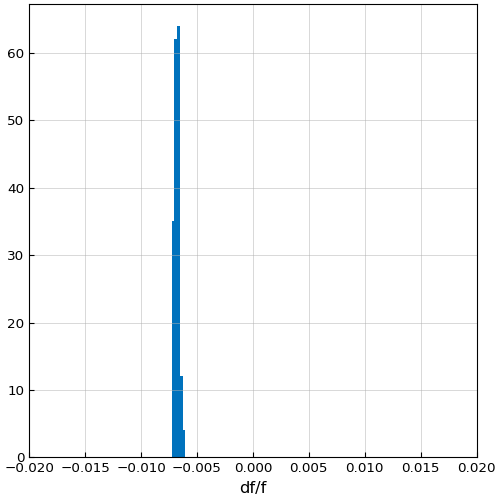

In [26]:
fig, ax = plt.subplot_mosaic('a', figsize=(5, 5), constrained_layout=True)
_ = ax['a'].hist(df_f_corr[idx_trim], bins=5)
ax['a'].set_xlabel('df/f')
ax['a'].set_xlim(-.02, .02)
np.save('df_f_trimmed.npy', df_f_corr[idx_trim])

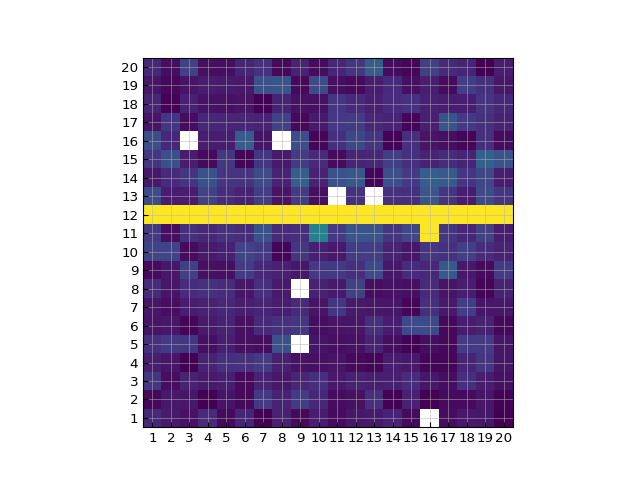

In [17]:
nr_scans = 20

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps
maps = map()
fig, ax = plt.subplots()
ax.imshow(maps[:, :, 11], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

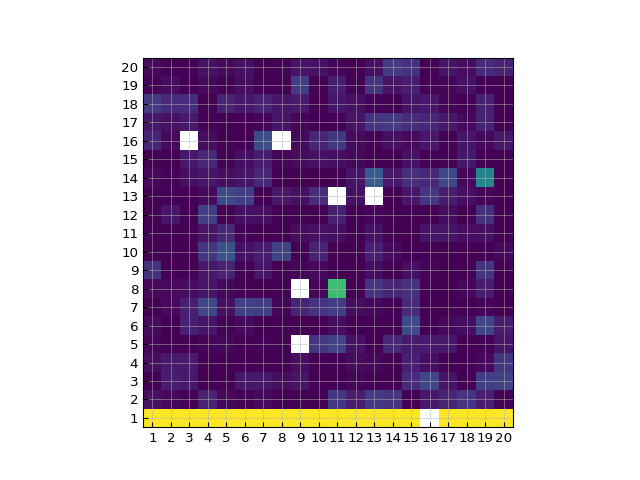

MovieWriter Pillow unavailable; using Pillow instead.


In [18]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
ani.save('animation_before.gif', writer='Pillow')

In [19]:
# 346 at (1, 7) not response
# 233 at (8, 6) not response
# 212 at (10, 15) has a double peak at 3 and 14, add to 3

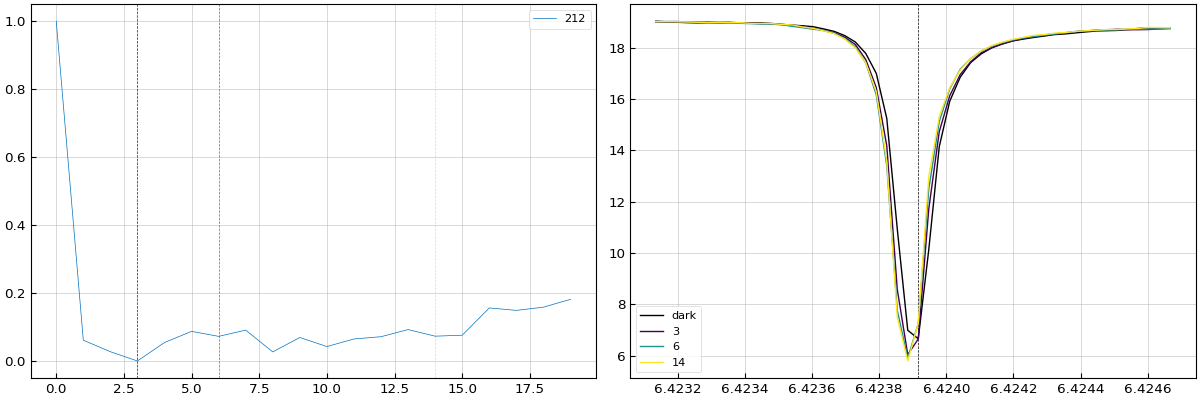

In [20]:
ids = np.arange(376, dtype=int)
ids = [212]
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 4), constrained_layout=True)
start = 0
stop = 20
# steps = np.arange(start, stop)
steps = [3, 6, 14]
bw = 25
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()